In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import sklearn.cluster as cluster
import hdbscan
import umap
import time

sns.set_context('talk')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
def plot_clusters_umap(data, algorithm, embedding, args, kwds, plot_kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [3]:
data = pd.read_csv(
    "../../data/results/probability-ctype_gene_protein-coding_CpG_Col-0_wt_root.bed",
    sep="\t",             
    header=None,
    names="chrom start end id score strand HMC MMC MSC LMC".split())

In [4]:
data.head()

chrom  start    end         id score strand       HMC       MMC       MSC  \
0      1  21120  33227  AT1G01040     .      +  0.424390  0.068293  0.016260   
1      1  45233  51304  AT1G01090     .      -  0.003058  0.009174  0.003058   
2      1  47908  53210  AT1G01100     .      -  0.003077  0.009231  0.003077   
3      1  49952  56737  AT1G01110     .      +  0.120603  0.017588  0.002513   
4      1  55163  61215  AT1G01120     .      -  0.122137  0.005089  0.002545   

        LMC  
0  0.491057  
1  0.984709  
2  0.984615  
3  0.859296  
4  0.870229

In [5]:
cytotypes = "HMC MMC LMC".split()
data_cytotypes = data[cytotypes]

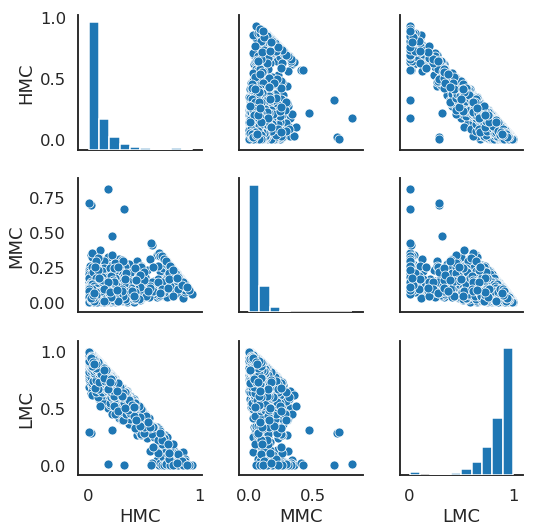

In [6]:
sns.pairplot(data_cytotypes)

Text(0.5, 0, 'LMC')

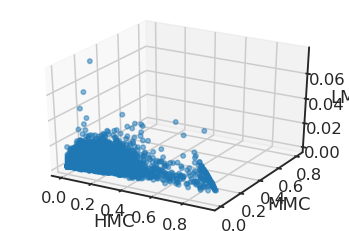

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["HMC"], data["MMC"], data["MSC"], zdir="z", alpha=0.5)
ax.set_xlabel("HMC")
ax.set_ylabel("MMC")
ax.set_zlabel("LMC")

In [8]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42
)

embedding = reducer.fit_transform(data_cytotypes)

embedding.shape

/home/oender/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


(9744, 2)

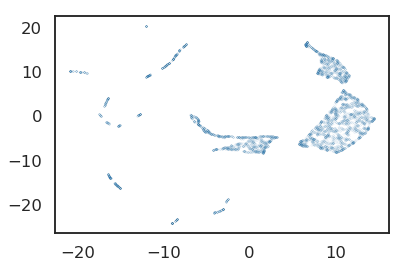

In [9]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5, s=.005)

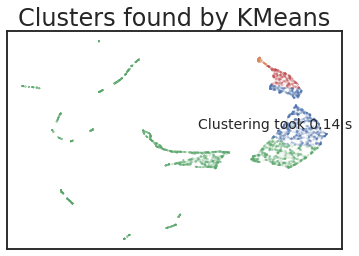

In [19]:
plot_clusters_umap(data_cytotypes, cluster.KMeans, embedding, (), {'n_clusters': 4}, {'s': 0.005})

In [85]:
k_means = cluster.KMeans(n_clusters=3).fit(data_cytotypes)
data["label_kmeans"] = k_means.labels_
data.groupby("label_kmeans").mean()

chrom         start           end       HMC       MMC  \
label_kmeans                                                             
0             3.134146  9.270227e+06  9.276786e+06  0.866597  0.111665   
1             2.882812  1.165190e+07  1.165782e+07  0.112557  0.072636   
2             3.122581  1.091351e+07  1.092005e+07  0.553007  0.120817   

                   MSC       LMC  label_hdbscan_embedding  
label_kmeans                                               
0             0.002715  0.019023                  1.69436  
1             0.003728  0.811078                  0.00000  
2             0.004375  0.321801                  0.00000

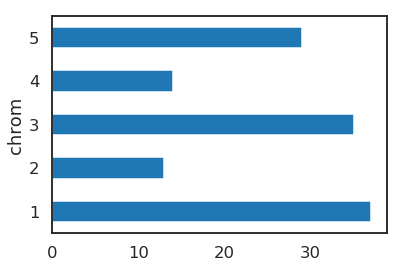

In [106]:
hdbclust = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=10).fit(embedding)
data["label_hdbscan_embedding"] = hdbclust.labels_
g = data.groupby("label_hdbscan_embedding")

In [107]:
g.size()

label_hdbscan_embedding
-1     127
 0     220
 1     237
 2     391
 3    3652
 4     208
 5     261
 6    2071
 7    2577
dtype: int64

In [108]:
g.mean()

chrom         start           end       HMC  \
label_hdbscan_embedding                                                   
-1                       2.874016  1.376096e+07  1.376586e+07  0.003744   
 0                       2.909091  1.392622e+07  1.393263e+07  0.002349   
 1                       2.949367  1.353295e+07  1.353942e+07  0.002259   
 2                       2.923274  1.407974e+07  1.408552e+07  0.002863   
 3                       2.955641  1.302440e+07  1.303042e+07  0.020378   
 4                       3.245192  1.397999e+07  1.398546e+07  0.003162   
 5                       2.954023  1.366126e+07  1.366649e+07  0.003428   
 6                       2.926606  1.224335e+07  1.224958e+07  0.070633   
 7                       3.001552  1.151449e+07  1.152088e+07  0.248087   

                              MMC       MSC       LMC  
label_hdbscan_embedding                                
-1                       0.003744  0.003744  0.988769  
 0                       0.002365  0.002349  0.992937  
 1                       0.002259  0.002259  0.993223  
 2                       0.002854  0.002854  0.991429  
 3                       0.027887  0.003669  0.948067  
 4                       0.003153  0.003162  0.990523  
 5                       0.003428  0.003438  0.989707  
 6                       0.066478  0.005185  0.857703  
 7                       0.096732  0.006717  0.648463

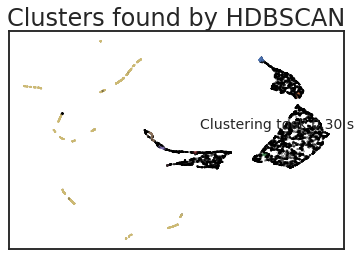

In [15]:
plot_clusters_umap(data_cytotypes, hdbscan.HDBSCAN, embedding, (), {'min_cluster_size': 5, 'min_samples': 100}, {'s': 0.1})